In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import cv2
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
# from tensorflow.keras import backend as K
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, Embedding, Concatenate
from tensorflow.keras.layers import add, concatenate, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import Activation, RepeatVector, Permute, Lambda, multiply, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

#### Parameter Setting

In [2]:
import cocoa                    # Load the dataset access utility
CV2_read_img = True             # Use CV2 Read image or PIL read image
RGB_EQ = True                   # RGB values balance in normalization
VGG16_img_pp = True             # Use default VGG16 img processing function 
img_size = (224, 224)           # Pre-assign the image size
Hidden_NN_enable = True         # Enable NN for Hidden Layer
Load_CNN = True                 # Load the VGG16 pre-trainied module 
RNN_batch_size = 1024           # Assign the batch size for the RNN
RNN_training = True             # Re-Train the RNN or use pre-trained model
RNN_cont_train = False          # Continue training based on previouse traind model
RNN_dropout = True              # Enable inter-layer dropout in RNN model 
RNN_epochs = 20                 # RNN training epochs
Caption_pre_select = False      # Pre-select caption on-line for training set 
Caption_filter = True           # Filter the out-lined captions
Clean_Caption = False           # Load pre-processed captions
K_fold_caption = False          # Enable K-fold of all captions for training 
Plot_RNN_model = True           # Plot the RNN model
Decoder_NN = False              # Enable NN and transfer value on output decoder (False) 
Glove_enable = True             # Glove Pretrained Word Embedding
Self_attention = True           # Self-Attention
Bleu_Score = True               # Display the Bleu score with the default caption.
Translate = False               # Display the caption in Chinese.
BERT_enable = False

In [3]:
# cocoa.set_data_dir("datasets/pixnet01/coco_2017")
cocoa.set_data_dir("../coco_2017")    # RAW Data Location
                                                    # Cache file for the image
cocoa.cache_dir = "cache_vgg16_p" if VGG16_img_pp else "cache_vgg16_b"

check_point_file = "checkpoint003a.keras"           #  feature transfer data.
clean_caption_file = "En_cap04.csv"

#### Image loading and Preprocessing

In [4]:
_, f_names_train, caps_train = cocoa.load_records(train=True)  # Load file names and captions in training set             
_, f_names_val,   caps_val   = cocoa.load_records(train=False) # Load file names and captions in validation set      
num_images_train = len(f_names_train)                          # Total images in trainning set.
print ('Total:', num_images_train, 'images loaded.') 

- Data loaded from cache-file: cache_vgg16_p/records_train.pkl
- Data loaded from cache-file: cache_vgg16_p/records_val.pkl
Total: 118287 images loaded.


Get the file path and captions from COCO Dataset

In [5]:
def lookup_ds(index, train=True):         # Return the path/cap of image      

    if train:                             # the train data-set with index.
        file_dir  = cocoa.train_dir 
        file_name = f_names_train[index] 
        captions  = caps_train[index]
    else:                                 # the val data-set with index.
        file_dir  = cocoa.val_dir
        file_name = f_names_val[index]   
        captions  = caps_val[index]        
    return  os.path.join(file_dir, file_name), captions

Load and resize the image from the image file

In [6]:
def load_image(path, size=None):                           # (Image Loading module V02)

    if CV2_read_img:                                       # Load the image using CV2.
        img = cv2.imread(path)               
        if not (size is None):                             # Resize image if size is assigned
            img = cv2.resize(img, dsize=size, 
                    interpolation=cv2.INTER_AREA)  
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)          # Change the color order.     
    else:
        img = Image.open(path)                             # Load the image using PIL.
        if not (size is None):                             # Resize image if size is assigned
            img = img.resize(size=size, 
                             resample=Image.LANCZOS)
        img = np.array(img) / 255.0                        # Convert image to numpy array.
                                                           # Nomalized to 0.0 and 1.0
    if (len(img.shape) == 2):                              # Convert GS array to RGB array.
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

Load the image and plot the image

In [7]:
def show_image(idx, train):                                 # Load the image and show the caption

    img_f_names, img_captions = lookup_ds(idx, train)  # Get img location and captions
    img = load_image(img_f_names)                           # Load image and display
    plt.imshow(img)
    plt.show()    
    print ("Default Captions:")                             # Display the default caption
    for caption in img_captions:
        print(" ",caption)

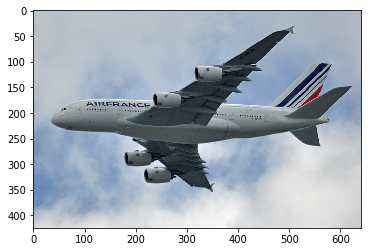

Default Captions:
  A big airplane flying in the big blue sky
  Large, two decked, four engined airliner in flight.
  An AirFrance jet airplane flying in the sky 
  A big plane with AirFrance on the side of it.
  An Air France air plane in mid flight.


In [8]:
show_image(idx=15, train=True)

#### Building CNN Model for Images

In [9]:
if Load_CNN:
    base_model = VGG16(weights='imagenet', include_top=True)     # Use VGG16 for base image model
    transfer_layer = base_model.get_layer('fc2')                 # Abstract the image features  
    image_model_transfer = Model( inputs  = base_model.input,    # Image Model for feature prediction
                                  outputs = transfer_layer.output)
    transfer_values_size = keras.backend.int_shape(transfer_layer.output)[1]
else:
    transfer_values_size=4096
print ('Image feature transfer value data shape:',transfer_values_size)

Image feature transfer value data shape: 4096


In [10]:
def print_progress(count, max_count):                          # Status display function
    sys.stdout.write("\r- Progress: {0:.1%}".format(count / max_count))
    sys.stdout.flush()                                         # Percentage completed.

#### Predict the Transfer Values and Save to Disk

In [11]:
def process_images(data_dir, filenames, batch_size=32):         # (Image process module v02)
                                                                # 32 pics batch, add CV2 read EQ 
    num_images = len(filenames)                                 # Number of images to process.
    shape = (batch_size,) + img_size + (3,)                     # Prepare the image array
    image_batch = np.zeros(shape=shape, dtype=np.float16)       # Default shape(32, 224, 224 ,3)
                                 
    shape = (num_images, transfer_values_size)                  # Preare for the transfer array
    transfer_values = np.zeros(shape=shape, dtype=np.float16)   # Default shape is (files, 4096)
                                   
    start_index = 0                                             # Index for the filenames.
    while start_index < num_images:                             # Batch reading image files.
        print_progress(count=start_index, max_count=num_images) # Print progress
                                                                # End of this batch.
        end_index = min(start_index+batch_size, num_images)     # The last batch may have a 
        current_batch_size = end_index - start_index            #      different batch-size.
                                                                # Load all the images in batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)             # Path of the image file
            img = load_image(path, size=img_size)               # Load and resize the image.
            image_batch[i] = img                                # Image into NP array
            if CV2_read_img:                                    # CV2 read post regulization
                if VGG16_img_pp:
                    image_batch[i] = preprocess_input(image_batch[i])
                else:
                    image_batch[i] /= 255.0 
                    if RGB_EQ:                                  # RGB Mean value balancing 
                        image_batch[i] -= [0.485, 0.456, 0.406]
                        image_batch[i] /= [0.229, 0.224, 0.225] # [0.5496, 0.5376, 0.54]
                                                                # Predict feature from the image.
        transfer_values_batch = \
                    image_model_transfer.predict(image_batch[0:current_batch_size])
                                                                # Save the transfer values
        transfer_values[start_index:end_index] = \
                    transfer_values_batch[0:current_batch_size]
        start_index = end_index                                 # Set the index for next loop.
            
    print()                                                     # Print newline.
    return transfer_values

In [12]:
def image_preprocess(train=True):   # Image pre-process to cache file (Image Prepocess module V02)
 
    if train;
        tr_file = "transfer_values_train.pkl"
        im_file = f_names_train
        im_dir  = cocoa.train_dir
    else:
        tr_file = "transfer_values_val.pkl"
        im_file = f_names_val
        im_dir  = cocoa.val_dir
   
    print ("Pre-processing {0} images in the {1} set..."
           .format( len(im_file), "training" if train else "validation"))

    transfer_values = cocoa.cache(cache_path=os.path.join(cocoa.cache_dir,tr_file),
                      fn=process_images, data_dir=im_dir, filenames=im_file)

    print("Data Shape:", transfer_values.shape, " Type:", transfer_values.dtype)   
    return transfer_values    

In [13]:
%%time
transfer_values_train = image_preprocess()

Pre-processing 118287 images in the training set...
- Data loaded from cache-file: cache_vgg16_p/transfer_values_train.pkl
Data Shape: (118287, 4096)  Type: float16
CPU times: user 175 ms, sys: 843 ms, total: 1.02 s
Wall time: 1.04 s


In [14]:
%%time
transfer_values_val = image_preprocess(train=False)

Pre-processing 5000 images in the validation set...
- Data loaded from cache-file: cache_vgg16_p/transfer_values_val.pkl
Data Shape: (5000, 4096)  Type: float16
CPU times: user 10.9 ms, sys: 8.44 ms, total: 19.3 ms
Wall time: 18.2 ms


#### Caption Pre-processing

In [15]:
mark_start = 'ssss '
mark_end = ' eeee'

Caption_pre_select = False if K_fold_caption else Caption_pre_select
num_tokens_train = [len(t) for t in caps_train]        # Number of caption for each pic

Outliner Caption filter 

In [16]:
def dum_cap(TX):                                       # Identify the out-lined captions
    dum1 = (TX[0]==TX[1])+(TX[0]==TX[2])+(TX[1]==TX[2])+\
            (TX[1]==TX[3])+(TX[2]==TX[3])+(TX[0]==TX[3])
    dum2 = (TX[0:2]=='I ') or (TX[0:2]=='i ')
    return (dum1>1) or dum2

In [17]:
def pick_cap(C):                                       # Filter the out-lined caption
    R = np.random.choice(C) 
    while dum_cap(R):
        R = np.random.choice(C)
    return R 

Re-marking the Captions with header and footer 

In [18]:
def mark_captions(captions_listlist):                    # Adding star-end marking on each caption
    if Caption_pre_select and not Clean_Caption:        
        cp_marked = [[mark_start + pick_cap(captions_list) + mark_end]
                    for captions_list in captions_listlist]     
    else:
        cp_marked = [[mark_start + caption + mark_end
                    for caption in captions_list]
                    for captions_list in captions_listlist]    
    return cp_marked

if Clean_Caption:                                        # Load pre-filtered caption set
    new_cap = pd.read_csv(clean_caption_file)
    caps_train_marked = mark_captions(new_cap.values)
else:                                                    # Load entire caption set
    caps_train_marked = mark_captions(caps_train)
# caps_train[10], caps_train_marked[10].lower

In [19]:
# Flatten the captions array in to 1-d for tokennizer
caps_train_flat = [caption                       
                     for captions_list in caps_train_marked
                     for caption in captions_list]

#### Build the Tokennizer Class and Wrap additional function.

In [20]:
num_words = 10000

class TokenizerWrap(Tokenizer):
   
    def __init__(self, texts, num_words=None):
        Tokenizer.__init__(self, num_words=num_words)
        self.fit_on_texts(texts)
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()   ))
    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token]
                 for token in tokens if token != 0]
        text = " ".join(words)
        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        return tokens

In [21]:
%%time
tokenizer = TokenizerWrap(texts=caps_train_flat,            
                          num_words=num_words)

CPU times: user 11.7 s, sys: 1.55 ms, total: 11.7 s
Wall time: 11.7 s


In [22]:
token_start = tokenizer.word_index[mark_start.strip()]   # Check the Token #
token_end   = tokenizer.word_index[mark_end.strip()]
token_start, token_end

(2, 3)

In [23]:
%%time
tokens_train = tokenizer.captions_to_tokens(caps_train_marked)

CPU times: user 10.1 s, sys: 103 ms, total: 10.2 s
Wall time: 10.3 s


In [24]:
tokens_train[0], caps_train_marked[0]

([[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
  [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
  [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
  [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
  [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]],
 ['ssss Closeup of bins of food that include broccoli and bread. eeee',
  'ssss A meal is presented in brightly colored plastic trays. eeee',
  'ssss there are containers filled with different kinds of foods eeee',
  'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
  'ssss A bunch of trays that have different food. eeee'])

### Data Generator

K_Fold option is randomly shuffle all captions (in each photo) into 5 folds for training. Default method is randomly select caption again in each batch.

In [25]:
if K_fold_caption:
    C_idx = np.random.randint(num_images_train, size=num_images_train)
K_fold_idx = 0

In [26]:
def pick_token(I,L):                  # Filtering the outlined token from outline captions
    R = np.random.choice(L) 
    while dum_cap(caps_train[I][R]):
        R = np.random.choice(L) 
    return R 

Applying different methode of random caption tokens selection.

In [27]:
def get_random_caption_tokens(idx, kf_idx):      # Get the captions in the image of the index array
       
    result = []                                  # Random select a caption
    for i in idx:                                #      if "pre-selection" is not enabled
        if Caption_pre_select or Clean_Caption:  # No Random choosing if pre-select caption 
            j = 0
        else:
            l = num_tokens_train[i]            
            if K_fold_caption:                   # Caption shift 1 for k-fold
                j = ( C_idx[i] + kf_idx ) % l
            else:
                j = pick_token(i,l) if Caption_filter else np.random.choice(l)                   

        tokens = tokens_train[i][j]              # Get the j'th caption of image i. 
        result.append(tokens)                    # Add to the list
    return result

### Bstch Generator

In [28]:
def batch_generator(batch_size):

    while True:        # List of random index for images in training-set.

        global K_fold_idx
        idx = np.random.randint(num_images_train, size=batch_size)  # Randan index for batch samples 
        transfer_values = transfer_values_train[idx]                # Get the transfer-values 
        tokens = get_random_caption_tokens(idx, K_fold_idx)         # Get the random selected caption 
        K_fold_idx = K_fold_idx + 1                                 #      of the selected image #.
#         num_tokens = [len(t) for t in tokens]                     # Count the number of tokens in all sequences.
#         max_tokens = np.max(num_tokens)                           # Max number of tokens.
        tokens_padded = pad_sequences(tokens,                       # Padding the token
                        maxlen=64, #max_tokens,                     #     into the same length.
                        padding='post', truncating='post')
                                                                    # Dict for the input-data.
        x_data = {'decoder_input'        : tokens_padded[:,0:-1],     
                  'transfer_values_input': transfer_values      }
        y_data = {'decoder_output'       : tokens_padded[:,1:  ]}   # Dict for the output-data.
        
        yield (x_data, y_data)

In [29]:
generator = batch_generator(batch_size=RNN_batch_size)
print ('Batch size:', RNN_batch_size)

Batch size: 1024


In [30]:
# Check the ouput of the generator
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]
batch_x['transfer_values_input'][0], batch_x['decoder_input'][0], batch_y['decoder_output'][0]

(array([2.781, 0.   , 0.   , ..., 0.   , 0.   , 0.   ], dtype=float16),
 array([   2,    1,   11,  706,   91,    1,   12, 2231,    1,  112,    8,
          14,  129,    4,   28,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([   1,   11,  706,   91,    1,   12, 2231,    1,  112,    8,   14,
         129,    4,   28,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

Calculete the steps per epochs

In [31]:
num_captions_train = [len(captions) for captions in caps_train]
total_num_captions_train = np.sum(num_captions_train)

In [32]:
# n_cap_div = 5 if (Caption_pre_select or Clean_Caption) else 1
steps_per_epoch = int(total_num_captions_train / RNN_batch_size)
steps_per_epoch

577

### GloVe Embedding Layer

In [33]:
if Glove_enable:                        # Glove Embedding (Glove Embedding module v01)
    from keras.initializers import Constant
    
    Glove_dir = 'glove/glove.6B.100d.txt'          # Pre-Trained glove dictionary
    Max_sequence_length = 128
    Embedding_DIM = 100
    embeddings_index = {}
    
    with open(Glove_dir) as f:                     # Loading the word vector
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
                             
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((num_words, Embedding_DIM))

    for word, i in word_index.items():
        if i > num_words -1:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:            # index=0 if Words not found in embedding.
            embedding_matrix[i] = embedding_vector
                                    # load pre-trained word embeddings into an Embedding layer
    Glove_embd_layer = Embedding(input_dim=num_words,    
                                output_dim=128,
                                embeddings_initializer=
                                 tf.keras.initializers.Constant(embedding_matrix),
                                input_length=Max_sequence_length,
                                name="GloVe_Embedding",
                                trainable=False)     # Set trainable=False to fix the embeddings 

Using TensorFlow backend.


Found 400000 word vectors.


### Building RNN Model for Caption Generator
Layer Definition for Decoder RNN. 

In [34]:
state_size = 256 if Hidden_NN_enable else 512        # RNN Initial state reduction by adding DNN
embedding_size = 128

transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')
decoder_transfer_map  = Dense(state_size, activation='tanh',
                              name='decoder_transfer_map')
decoder_transfer_int  = Dense(state_size, activation='relu',
                              name='decoder_transfer_int')
decoder_input = Input(shape=(None, ), name='decoder_input')

word_embedding = Glove_embd_layer if Glove_enable else \
                 Embedding( input_dim=num_words,
                            output_dim=embedding_size,
                            name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)

decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)

decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)

decoder_dense = Dense(num_words,activation='linear', name='decoder_output')

drop_out = lambda Layer : Dropout(0.2)(Layer) if RNN_dropout else Layer   # Set the RNN Dropout layer

### Modeling the decorder RNN

In [35]:
def connect_decoder(transfer_values):       # Decoder model definintion (Decoder_model v05)
 
    initial_state = decoder_transfer_map(transfer_values)   # Image feature input form VGG16
    initial_state = Dropout(0.4)(initial_state)             # Dropout layer
    
    if Hidden_NN_enable:                                    # Adding a NN as the hidden layer
        initial_state = decoder_transfer_int(initial_state)
        initial_state = Dropout(0.4)(initial_state)         # Dropout layer
    
    net = decoder_input                                     # input caption form generator
    
    net = word_embedding(net)                               # Connect the embedding-layer.
                                                            #  Select defalt/GloVe in the layer def.
    if Self_attention:                                      # Self Attention Model 
        att = TimeDistributed(Dense(1, activation='tanh'))(net)
        att = Flatten()(att)
        att = Activation('softmax')(att)
        att = RepeatVector(128)(att)
        att = Permute([2,1])(att)

        rep = multiply([net, att])
        rep = Lambda(lambda xin: K.sum(xin, axis=-1, keepdims=True))(rep)

        dec = concatenate([net, rep], axis=-1)
        dec = BatchNormalization(-1)(dec)

        dec = drop_out(dec)                                     # RNN Layers
        dec = decoder_gru1(dec, initial_state=initial_state)    # Img feature connect to the GRU layers.
        dec = drop_out(dec) 
        dec = decoder_gru2(dec, initial_state=initial_state)
        dec = drop_out(dec) 
        dec = decoder_gru3(dec, initial_state=initial_state)
        
        decoder_output = decoder_dense(dec)                     # Connect to final Dense for decoding words

    else:                                                       # Decoder Model without Self Attention
        net = drop_out(net)                                     # RNN for caption generation
        net = decoder_gru1(net, initial_state=initial_state)    # Feature connect all the GRU layers.
        net = drop_out(net)   
        net = decoder_gru2(net, initial_state=initial_state)
        net = drop_out(net)  
        net = decoder_gru3(net, initial_state=initial_state)  
        
        if Decoder_NN:
            decoder_output = add([initial_state, net])
            decoder_output = Dense(256, activation='relu')(net)
            decoder_output = Dropout(0.2)(decoder_output)
            decoder_output = decoder_dense(decoder_output)
        else:
            decoder_output = decoder_dense(net)             # Connect to final Dense for decoding words
    
#     decoder_output = decoder_dense(net)
    return decoder_output

### Model Compile

In [36]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)
decoder_model  = Model( inputs=[transfer_values_input, decoder_input],
                       outputs=[decoder_output])

### Loss Function 

In [37]:
def sparse_cross_entropy(y_true, y_pred):           # Define the customer lost function
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [38]:
optimizer = RMSprop(lr=1e-3)
# optimizer = "Nadam"
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
#                       loss='sparse_categorical_crossentropy',
                      target_tensors=[decoder_target])

### Plot the RNN model graph

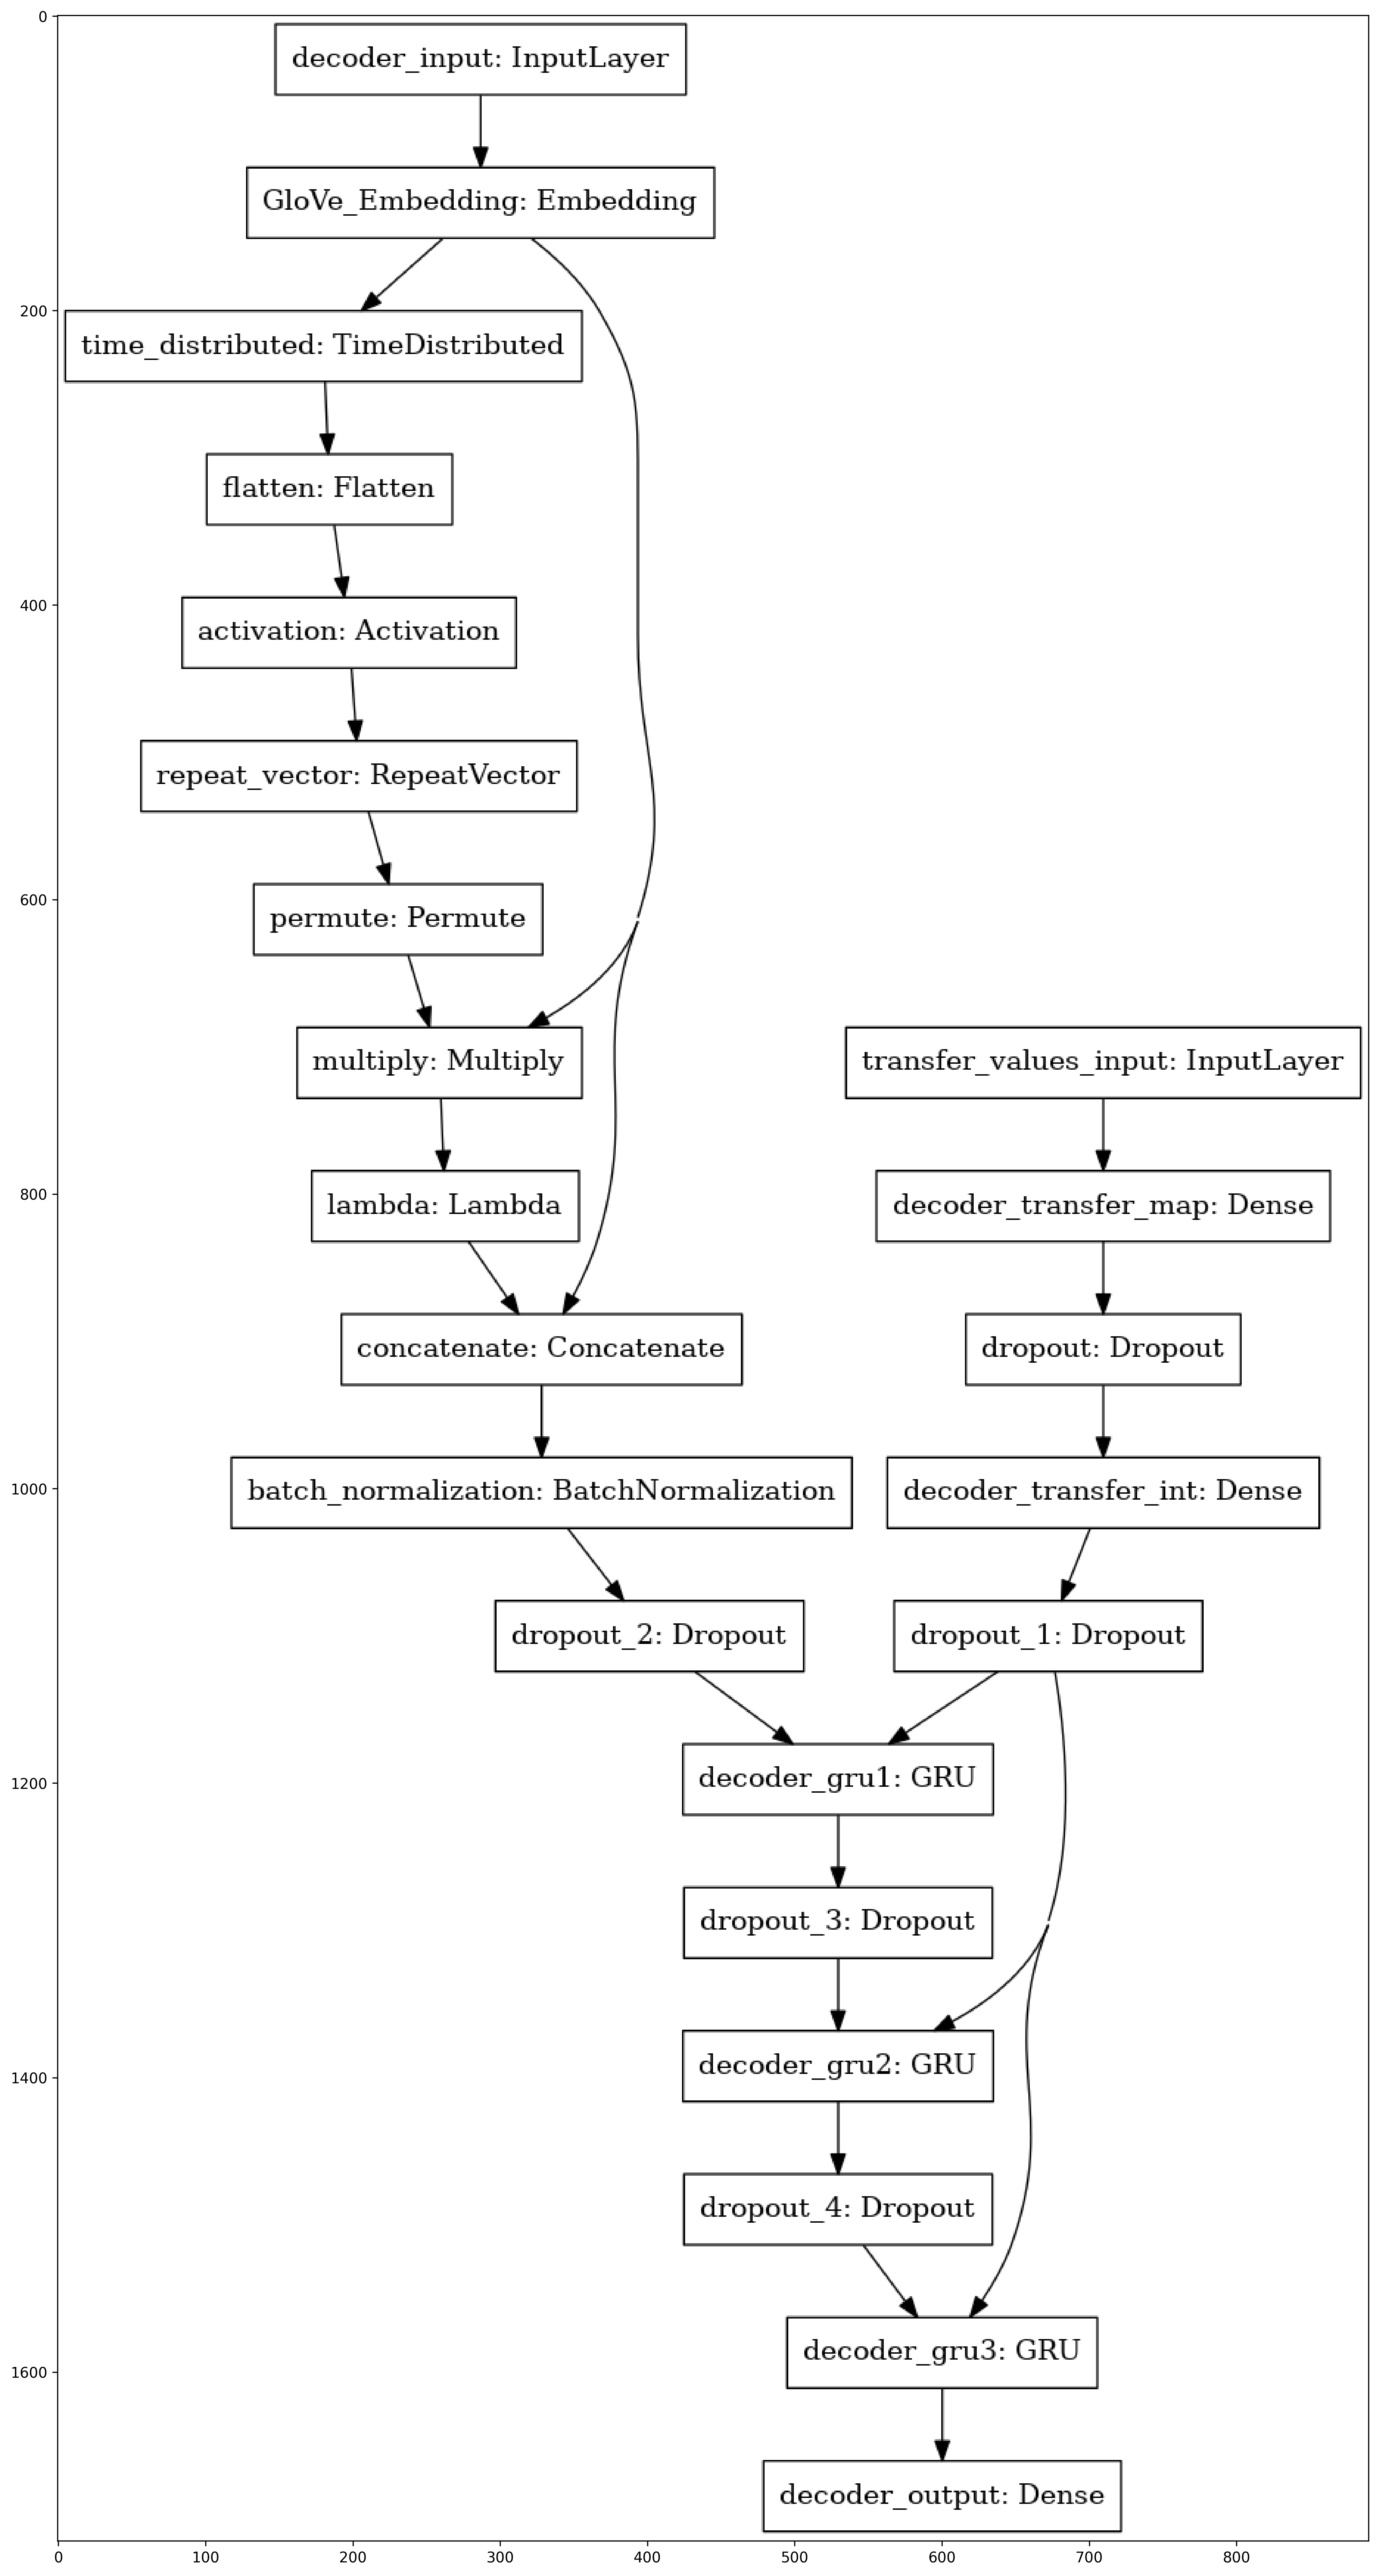

In [43]:
# RNN Model Graph output (RNN model graphic module  v01)
# ! pip install pydot
if Plot_RNN_model:
    from keras.utils import plot_model
    plot_model(decoder_model, show_shapes=False, to_file='decoder_model.png')
    plt.figure(figsize=(48,32), frameon=False, dpi=300)
#     plot_model(decoder_model, show_layer_names=True, show_shapes=False, rankdir='LR', to_file='decoder_model.png')
#     plt.figure(figsize=(48,32),frameon=False, dpi=300)
    plt.imshow(cv2.imread('decoder_model.png'))
    plt.show()

### Callback Function

In [44]:
# Call-back function (Call-back module  v01)
callback_CP = ModelCheckpoint( filepath=check_point_file, verbose=1, save_weights_only=True)
callback_TB = TensorBoard( log_dir='./log/', histogram_freq=0, write_graph=False)
callbacks = [callback_CP, callback_TB]

### Model Training

In [39]:
%%time
# RNN_Training  (RNN training control module  v02)
if RNN_cont_train or not RNN_training:                        # Load the pre-trained model
    try:                                                      # from the check point.
        decoder_model.load_weights(check_point_file)
    except Exception as error:
        print("Error loading checkpoint.")
        print(error)        

if RNN_training or RNN_cont_train:                            # RNN Training Process
    decoder_model.fit_generator(generator=generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=RNN_epochs,
                                callbacks=callbacks)        

CPU times: user 569 ms, sys: 203 ms, total: 772 ms
Wall time: 798 ms


### Caption Generating

In [40]:
if Bleu_Score:                                                # Import libray for Bleu
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.translate.bleu_score import corpus_bleu

In [41]:
if Translate:                                                  # Google Translation Modeule
#     ! pip install googletrans
    from googletrans import Translator
    translator = Translator()

In [42]:
def generate_caption(image_path, max_tokens=32):               # (Caption gen module   v01)

    image = load_image(image_path, size=img_size)              # Load and resize the image.
    image_batch = np.expand_dims(image, axis=0)                # Batch for 1 image
                                                               # Predit the image feature
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)                                    # Prepare 2D array for decoder
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start                                    # Start with 'ssss '.
    output_text, count_tokens  = '', 0                         # Initialize an empty output-text.
                                                               # Init number of tokens processed.
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int        # Input last sampled token until 
                                                               #     ' eeee' or max # of tokens.
        x_data = {'transfer_values_input': transfer_values,    # Prepare for input data into set
                  'decoder_input'        : decoder_input_data }  
        
        decoder_output = decoder_model.predict(x_data)         # predicted output.
        token_onehot = decoder_output[0, count_tokens, :]      # Get the last predicted token array.
        token_int = np.argmax(token_onehot)                    # Convert to an integer-token.
        sampled_word = tokenizer.token_to_word(token_int)      # Lookup the word corresponding to this integer-token.
        output_text += " " + sampled_word                      # Append the word to the output-text.
        count_tokens += 1                                      # Increment the token-counter.

    output_text = output_text.replace(mark_end,'.').lstrip().capitalize()
    output_tokens = decoder_input_data[0]                      # Sequence of tokens output by the decoder.

    plt.imshow(image)                                          # Plot the image.
    plt.show()
    print("Predicted caption:\n  {}".format(output_text))      # Print the predicted caption.
    if Translate:
        print(' {} \n'.format(translator.translate(output_text, dest='zh-TW').text)) 

    return list(output_text)   

In [43]:
def generate_caption_coco(idx, train=False):                   # Coco caption gen module   v02

    img_f_names, img_captions = lookup_ds(idx, train)          # Get image location and captions
    gen_caption = generate_caption(image_path=img_f_names)     # To generate a caption of the image.
    print("Default captions:")                                 # Print the default captions 
    true_captions = list()
    for caption in img_captions:                               #            from the data-set.
        print(' ',caption)
        if Translate:
            print(' ', translator.translate(caption, dest='zh-TW').text) 
        true_captions.append(list(caption))
        
    if Bleu_Score: 
        BS = np.zeros((4,2))                                    # Sentence BLEU evaluate
        BS[0,0] = sentence_bleu(true_captions, gen_caption, weights=(1, 0, 0, 0))
        BS[1,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 1, 0, 0))
        BS[2,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 0, 1, 0))
        BS[3,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 0, 0, 1))

        reference  = [true_captions]                            #Corpus BLEU evaluate
        candidates = [gen_caption]
        BS[0,1] = corpus_bleu(reference, candidates, weights=(1.0,  0,    0,    0   ))
        BS[1,1] = corpus_bleu(reference, candidates, weights=(0.5,  0.5,  0,    0   ))
        BS[2,1] = corpus_bleu(reference, candidates, weights=(0.3,  0.3,  0.3,  0   ))
        BS[3,1] = corpus_bleu(reference, candidates, weights=(0.25, 0.25, 0.25, 0.25))
        
        print ("\n  BLEU Score    Sentence      Corpus \n"+"-"*40)
        for i in range (4):
            print ('   BLEU-%d    %10.3f   %10.3f'%(i, BS[i,0], BS[i,1]))
        print ("-"*40,"\n")            

### Evaluate the performance
Evaluating the Bleu Score with the eval-set in COCO dataset.
Caption Generator without print:

In [44]:
def eval_caption(image_path, max_tokens=32):               # (Caption gen module   v03)

    image = load_image(image_path, size=img_size)              # Load and resize the image.
    image_batch = np.expand_dims(image, axis=0)                # Batch for 1 image
                                                               # Predit the image feature
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)                                    # Prepare 2D array for decoder
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start                                    # Start with 'ssss '.
    output_text, count_tokens  = '', 0                         # Initialize an empty output-text.
                                                               # Init number of tokens processed.
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int        # Input last sampled token until 
                                                               #     ' eeee' or max # of tokens.
        x_data = {'transfer_values_input': transfer_values,    # Prepare for input data into set
                  'decoder_input'        : decoder_input_data }  
        
        decoder_output = decoder_model.predict(x_data)         # predicted output.
        token_onehot = decoder_output[0, count_tokens, :]      # Get the last predicted token array.
        token_int = np.argmax(token_onehot)                    # Convert to an integer-token.
        sampled_word = tokenizer.token_to_word(token_int)      # Lookup the word corresponding to this integer-token.
        output_text += " " + sampled_word                      # Append the word to the output-text.
        count_tokens += 1                                      # Increment the token-counter.

    output_text = output_text.replace(mark_end,'.').lstrip().capitalize()
    output_tokens = decoder_input_data[0]                      # Sequence of tokens output by the decoder.

    return list(output_text)   

In [52]:
def eval_caption_coco(idx, train=False):                   # Coco caption gen module   v02

    img_f_names, img_captions = lookup_ds(idx, train)     # Get image location and captions
    gen_caption = eval_caption(image_path=img_f_names)     # To generate a caption of the image.
    true_captions = list()
    for caption in img_captions:                               #            from the data-set.
        true_captions.append(list(caption))
        
    if Bleu_Score: 
        BS = np.zeros((4,2))                                    # Sentence BLEU evaluate
        BS[0,0] = sentence_bleu(true_captions, gen_caption, weights=(1, 0, 0, 0))
        BS[1,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 1, 0, 0))
        BS[2,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 0, 1, 0))
        BS[3,0] = sentence_bleu(true_captions, gen_caption, weights=(0, 0, 0, 1))

        reference  = [true_captions]                            #Corpus BLEU evaluate
        candidates = [gen_caption]
        BS[0,1] = corpus_bleu(reference, candidates, weights=(1.0,  0,    0,    0   ))
        BS[1,1] = corpus_bleu(reference, candidates, weights=(0.5,  0.5,  0,    0   ))
        BS[2,1] = corpus_bleu(reference, candidates, weights=(0.3,  0.3,  0.3,  0   ))
        BS[3,1] = corpus_bleu(reference, candidates, weights=(0.25, 0.25, 0.25, 0.25))
        
#     if BS[0,0] >= 0.98  or BS[0,1] >= 0.98:                   # Print out the high score sample 
#         generate_caption_coco(idx, train)
    return BS        

In [61]:
val_len=len(f_names_val) 
B=[eval_caption_coco(i, train=False) for i in tqdm(range(val_len))]

100%|██████████| 5000/5000 [22:59<00:00,  3.38it/s]


In [64]:
np.array(B).mean(axis=0)                           # Bleu Average Matrix  

array([[0.87382923, 0.87382923],
       [0.65406761, 0.75336601],
       [0.44444495, 0.64730692],
       [0.35474892, 0.53196768]])

### Model Test

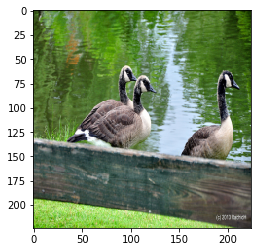

Predicted caption:
  A flock of ducks swimming around a pond.
Default captions:
  three ducks next to the shore of a pond
  A flock of ducks floating on top of a lake.
  The three ducks are by the water outside.
  Three geese that are standing by a pond.
  Three ducks walking along a dock near the water.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.900        0.900
   BLEU-1         0.795        0.846
   BLEU-2         0.658        0.798
   BLEU-3         0.568        0.719
---------------------------------------- 



In [56]:
generate_caption_coco(idx=165, train=True)

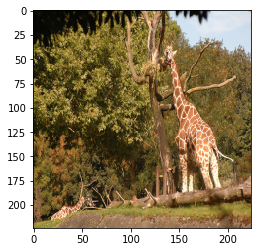

Predicted caption:
  A giraffe standing alone near some trees.
Default captions:
  A giraffe eating food from the top of the tree.
  A giraffe standing up nearby a tree 
  A giraffe mother with its baby in the forest.
  Two giraffes standing in a tree filled area.
  A giraffe standing next to a forest filled with trees.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.907        0.907
   BLEU-1         0.767        0.834
   BLEU-2         0.620        0.771
   BLEU-3         0.563        0.702
---------------------------------------- 



In [57]:
generate_caption_coco(idx=1, train=True)

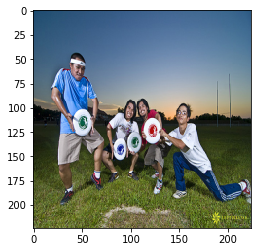

Predicted caption:
  A woman with a frisbee standing by her dog.
Default captions:
  A group of people hold up Frisbees for the camera.
  A group of people holding frisbees on a field. 
  A group of people in a field smile holding frisbees.
  Several people posing in a field while holding frisbees.
  A group of people playing with Frisbee's on the grass.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.848        0.848
   BLEU-1         0.564        0.691
   BLEU-2         0.333        0.571
   BLEU-3         0.251        0.447
---------------------------------------- 



In [58]:
generate_caption_coco(idx=128, train=False)

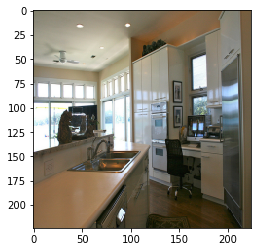

Predicted caption:
  A bathroom with a sink toilet and shower.
Default captions:
  A WHITE KITCHEN WITH ALL THE APPLIANCES AND COMPUTER AREA
  A kitchen counter with sink beside a workspace area
  A view of kitchen sink and a desk area.
  A large open kitchen with a computer work station.
  a kitchen with tan counters wooden floors and a desk

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.976        0.976
   BLEU-1         0.575        0.749
   BLEU-2         0.333        0.605
   BLEU-3         0.263        0.471
---------------------------------------- 



In [59]:
generate_caption_coco(idx=12555, train=True)

In [ ]:
for l in range (10):
    generate_caption_coco(idx=559 + l, train=False)

In [ ]:
for l in range (10):
    generate_caption_coco(idx=3345 + l, train=False)

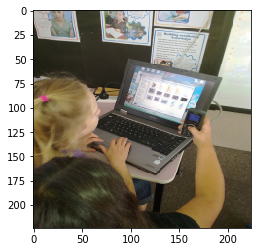

Predicted caption:
  A woman using her laptop computer at her desk.
Default captions:
  A couple of people with a laptop at a table.
  Student working on the computer while another student shows her a mobile phone. 
  Two girls at a desk playing with a laptop.
  A couple of children sitting down next to a laptop computer.
  A woman holds a phone next to the laptop a child is working on.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.889        0.943
   BLEU-2         0.773        0.893
   BLEU-3         0.628        0.810
---------------------------------------- 



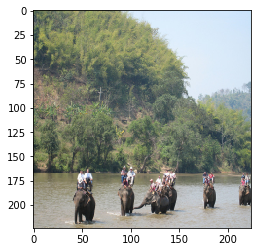

Predicted caption:
  A group of people standing around a river.
Default captions:
  A herd of elephants walking down a river with people riding on their backs.
  an image of people riding elephants in the water
  Many tourists riding on elephants in a river
  A group of people cross a river while riding elephants.
  People are riding on elephants in a river.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.976        0.976
   BLEU-1         0.854        0.913
   BLEU-2         0.675        0.841
   BLEU-3         0.590        0.759
---------------------------------------- 



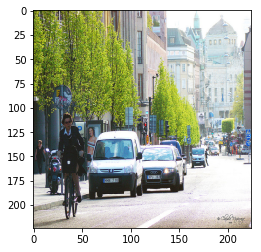

Predicted caption:
  A busy city street filled with lots of traffic.
Default captions:
  a person riding on a bicycle on the street in front of some cars
  The cars are travelling behind the guy on the bicycle
  a woman rides a bike in front of some cars 
  A woman on a bike rides on the street in front of cars.
  A woman is riding her bike down the street in front of traffic.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.979        0.979
   BLEU-1         0.630        0.786
   BLEU-2         0.378        0.646
   BLEU-3         0.318        0.522
---------------------------------------- 



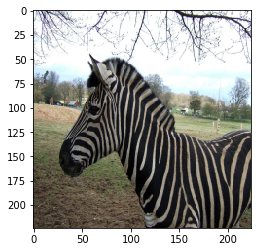

Predicted caption:
  A zebra standing alone with its head open.
Default captions:
  A zebra standing on top of a grass covered field.
  there is a very beautiful zebra that is standing in the shade
  A zebra showing the left side of itself on a field.
  A zebra is standing in an open field.
  a large zebra standing next to a tree

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.829        0.911
   BLEU-2         0.500        0.768
   BLEU-3         0.436        0.652
---------------------------------------- 



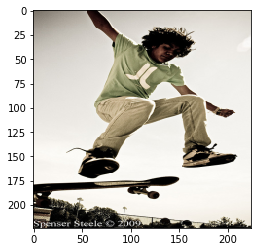

Predicted caption:
  A skateboarder is doing tricks at night.
Default captions:
  A man flying through the air while riding a skateboard.
  A man is doing tricks on a skateboard.
  A skateboarder jumps while trying to perform a trick.
  a man in the air standing above the skateboard
  a person attempting a jump with a skateboard

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.846        0.920
   BLEU-2         0.763        0.877
   BLEU-3         0.703        0.821
---------------------------------------- 



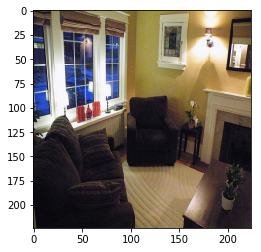

Predicted caption:
  A living room filled with furniture and a window.
Default captions:
  A living room with dark colored furniture and a fire place.
  A room with brown sofa and chair, tables, a fireplace, and white windows.
  A view of a large well decorated living room.
  A living room with a white carpet and black furniture.
  a living room with a couch and a chair 

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.980        0.980
   BLEU-1         0.938        0.958
   BLEU-2         0.851        0.929
   BLEU-3         0.717        0.865
---------------------------------------- 



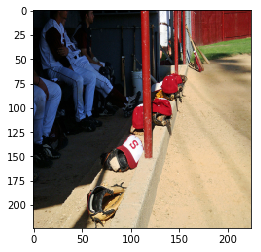

Predicted caption:
  A man riding a skateboard over a cement wall.
Default captions:
  A group of guys in  a dugout with their gear 
  A group of baseball players sit with their gear in the dugout.
  Some baseball players sitting in a dugout watching a game
  A dug out filled with baseball players next to baseball equipment.
  Many caps and gloves sit in front of the players in a baseball dugout.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.978        0.978
   BLEU-1         0.659        0.803
   BLEU-2         0.279        0.598
   BLEU-3         0.119        0.383
---------------------------------------- 



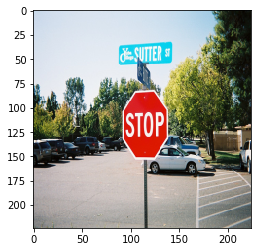

Predicted caption:
  A stop sign with street signs attached to it.
Default captions:
  A red stop sign sitting under a couple of street signs.
  A stop sign is posted next to a parking lot.
  a top sign sitting in a parking lot full of cars
  A stop sign stands at the corner of Sutter Street.
  a red stop sign with a street sign attached

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.977        0.989
   BLEU-2         0.860        0.949
   BLEU-3         0.762        0.895
---------------------------------------- 



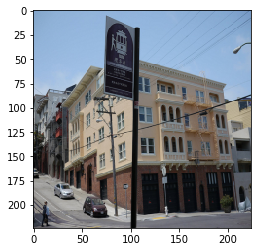

Predicted caption:
  A city street with tall buildings and traffic lights.
Default captions:
  A big building perched atop a hill with a sign in the foreground.
  A sign letting readers know that there is a train. 
  A historic trolley sign is across the street from a large building.
  A city street with a road sign next to some buildings
  A row of buildings and a city street on a hill that is pretty steep.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.981        0.981
   BLEU-1         0.808        0.890
   BLEU-2         0.667        0.826
   BLEU-3         0.580        0.744
---------------------------------------- 



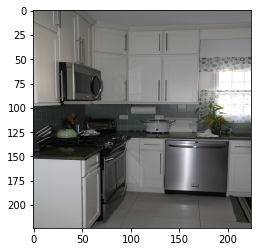

Predicted caption:
  A kitchen with wooden cabinets and white appliances.
Default captions:
  A kitchen filled with metal appliances and a window.
  A home kitchen with white cabinets and silver appliances
  This is a black and white photo of a white kitchen.
  An empty clean kitchen with cabinetry, stove and dishwasher.
  A KITCHEN WITH A SINK AND APPLIANCES 

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.863        0.929
   BLEU-2         0.840        0.908
   BLEU-3         0.776        0.866
---------------------------------------- 



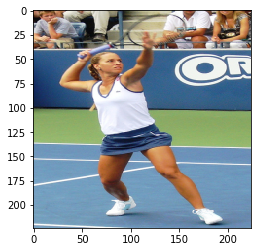

Predicted caption:
  A tennis player prepares to serve the ball.
Default captions:
  A woman holding a tennis racket in her hand
  A woman prepares to swing her tennis racket
  A tennis player prepares to serve the ball.
  A tennis player is swinging at a tennis ball.
  a woman raising her arms up so she can serve a tennis ball 

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         1.000        1.000
   BLEU-2         1.000        1.000
   BLEU-3         1.000        1.000
---------------------------------------- 



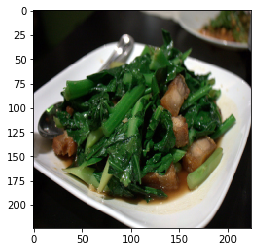

Predicted caption:
  A bowl filled with pasta and vegetables.
Default captions:
  A white plate of food tha includes meat and vegetables.
  a plate with meat and green veggies mixed with sauce 
  A white plate of food on a table.
  A plate of pork with chinese broccoli drizzled with sauce
  Assortment of cooked vegetable on white plate on table.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.975        0.975
   BLEU-1         0.744        0.851
   BLEU-2         0.553        0.760
   BLEU-3         0.514        0.673
---------------------------------------- 



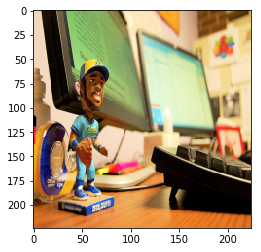

Predicted caption:
  A man with a laptop computer with a large screen.
Default captions:
  A baseball player bobble head next to two computer monitors on a desk.
  A close of a bobble head doll with a computer in the background.
  A bobble head is shown next to computer screens.
  A bobble head baseball figurine on a desk. 
  A desk with two computer screens and a Cecil Cooper bobble head.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.980        0.980
   BLEU-1         0.688        0.821
   BLEU-2         0.426        0.687
   BLEU-3         0.348        0.562
---------------------------------------- 



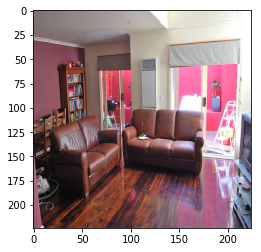

Predicted caption:
  A living room filled with furniture and a window.
Default captions:
  A large living room with leather couches and wood flooring
  A living room filled with two leather couches on a hard wood floor.
  The living room is spacious and clean with hardwood floors and seating on leather sofas.
  Two brown leather couches in a living room
  A living room with brown, leather furniture and a red wall

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.938        0.968
   BLEU-2         0.830        0.927
   BLEU-3         0.804        0.889
---------------------------------------- 



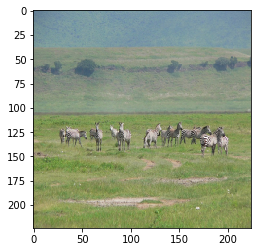

Predicted caption:
  A herd of cattle grazing on grass.
Default captions:
  A herd of zebra stand on a plain in the wild.
  A group of zebras on a green plain
  A herd of zebra are grazing in a grassy meadow.
  A group of zebra stand in the plain.
  A large group of zebras in a open field.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.971        0.971
   BLEU-1         0.788        0.874
   BLEU-2         0.688        0.825
   BLEU-3         0.581        0.743
---------------------------------------- 



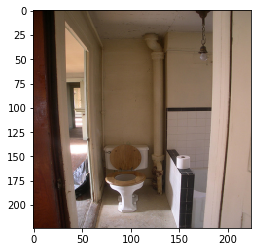

Predicted caption:
  A bathroom with a sink toilet and shower.
Default captions:
  a bath room with a toilet and toilet paper 
  A bathroom that has a small dividing wall next to it.
  A narrow bathroom with little room for movement. 
  A bathroom with a toilet and bathtub beside a hallway.
  A small bathroom with old toilet and tub

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.976        0.976
   BLEU-1         0.825        0.897
   BLEU-2         0.692        0.839
   BLEU-3         0.658        0.778
---------------------------------------- 



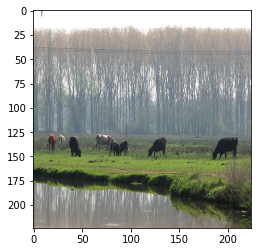

Predicted caption:
  A large herd of elephants walking across a river.
Default captions:
  A group of cows grazing in a field near a body of water.
  Several animals standing in the grass near a lake.
  Several cows grazing on grass near water with trees in the background.
  a herd of cows graze lazily by the pond
  A herd of cattle grazing on top of a grass covered field.

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         0.980        0.980
   BLEU-1         0.674        0.812
   BLEU-2         0.313        0.622
   BLEU-3         0.149        0.419
---------------------------------------- 



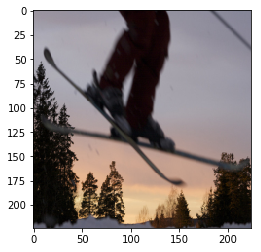

Predicted caption:
  A man flying through the air while riding skis.
Default captions:
  A man riding skis while flying through the air.
  A person snowboarding outside while the sun is setting . 
  There is a person skiing on a hill.
  Sunset with a skiers feet and skis in the foreground
  A fuzzy picture of a man in the middle of a skiing jump

  BLEU Score    Sentence      Corpus 
----------------------------------------
   BLEU-0         1.000        1.000
   BLEU-1         0.957        0.978
   BLEU-2         0.889        0.952
   BLEU-3         0.818        0.913
---------------------------------------- 



In [63]:
k = 1000
for l in range (200):
    eval_caption_coco(idx=k + l, train=False)